# Hate speech classifier

### Training a classifier to recognise hate speech on Twitter

In this notebook, we are going to train a 'classifier' (a supervised machine learning algorithm) to recognise hate speech in a tweet. This is a technique of **Natural Language Processing (NLP)** similar to Sentiment Analysis.

This requires two phases:
- 1. **Train the classifier** (show the algorithm examples of both hateful and non-hateful tweets)
- 2. **Test the accuracy of the classifier**



First let's import the libraries we are going to need

In [1]:
import os
import pandas as pd
import re
import string
import numpy as np
import matplotlib
import operator 
import pickle

import nltk # nltk 3.4
print('The nltk version is {}.'.format(nltk.__version__))
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk import ngrams

from sklearn.utils import shuffle

The nltk version is 3.4.5.


[nltk_data] Downloading package stopwords to /Users/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tell python where it can find the data files (they're in a `data` sub-directory of the current folder)

In [8]:
#os.chdir("C:/Users/mednche/Desktop/Hate-speech-twitter-NLP/")
os.chdir(os.getcwd()+"/data/")
os.getcwd()

'/Users/nick/gp/n8-prp-ml-practicals/Hate-speech-classifier/data'

## Import pre-labeled Twitter dataset

Let's import the dataset used to train and test the classifier

In [9]:
data = pd.read_csv('TrainingTweets.csv', encoding='ISO-8859-1')
data.shape

(310, 2)

'data' a Pandas dataframe. Let's see what it looks like. 

In [15]:
# Display the last 5 rows of the dataframe
data.tail()

,tweet,class
305,well yes i mean you started off saying third l...,0
306,so my neighbours complained about my shed in t...,1
307,fucking fascist fucking liberal fucking racist...,1
308,fucking annoying when meat dairy and eggs are ...,0
309,i hate people i was wrong when i said 97.5 of ...,1


Note: you can see that each tweet has already been manually labeled in the column 'class'.
- 1 means hateful
- 0 means non-hateful

This label is essential for what we are going to do (supervised machine learning).

##   Ensure balance in dataset

Let's see how many hateful vs non-hateful tweets there are in the dataset

In [16]:
hate_tweets = data[data["class"] == 1]
print("{} hateful tweets".format(len(hate_tweets)))

nonhate_tweets = data[data["class"] == 0]
print("{} non-hateful tweets".format(len(nonhate_tweets)))

101 hateful tweets
209 non-hateful tweets


In [17]:
hate_tweets.head()

,tweet,class
0,Muslims go to fucking home bye bye #brexit',1
1,'Muslim scum terrorists',1
2,'Go home you immigrant',1
3,'Polish vermin',1
4,'Polish bastard',1


In [18]:
nonhate_tweets.head()

,tweet,class
59,'@16po @realDonaldTrump I don\'t_ terrorism is...,0
60,'I am absolutely dreading tomorrow. I hate it ...,0
61,'RT @washingtonpost: The Rev. William Barber d...,0
62,'RT @RedP1llReport: David Icke_ Political Corr...,0
63,'My best RTs this week came from: @SkimmySkinn...,0


There seems to be twice as many non-hateful tweets. This might affect the way the algorithm learns. We need to make the dataset balanced.

####  Select as many hateful as non-hateful tweets for an equal dataset

In [19]:
num = min(len(hate_tweets), len(nonhate_tweets))

# shuffle the table of hateful and non hateful tweets
hate_tweets = shuffle(hate_tweets)
nonhate_tweets = shuffle(nonhate_tweets)

data_balanced = hate_tweets[0:num].append(nonhate_tweets[0:num], ignore_index=True)

print('Number of tweets in balanced dataset: {}'.format(len(data_balanced)))

Number of tweets in balanced dataset: 202


In [20]:
data_balanced.head()

,tweet,class
0,fucking fascist fucking liberal fucking racist...,1
1,'All the coloured fuckers can leave the country',1
2,fuck u jezanie u cunts cbb,1
3,'That fucking white bitch down the road needs ...,1
4,"""you're just a black nigger""",1


## Part I. Preprocessing

In this part we'll perform some preprocessing on the column 'tweet'. It will do things like turn the text all into lowercase, get rid of urls, remove usernames, etc. Have a look at the comments in the code below to see precisely what it's doing.

### Clean tweets

In [21]:
def cleanTweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to ''
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Remove the RT before the @user 
    tweet = re.sub('rt','',tweet) 
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove @username
    tweet = re.sub('@[^\s]+','',tweet) 
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Remove non ASCII characters (emojies)
    tweet= re.sub(r'[^\x00-\x7F]+','', tweet)
    #Remove punctuation 
    tweet = "".join(l for l in tweet if l not in string.punctuation)
    #Trim
    tweet = tweet.strip('\'"')
    #Remove beginning and end space
    tweet = tweet.strip()

    
    return tweet

#  apply cleaning function to each tweet of the pandas dataframe
data_balanced['tweet'] = data_balanced['tweet'].apply(cleanTweet)

In [22]:
data_balanced.head()

,tweet,class
0,fucking fascist fucking liberal fucking racist...,1
1,all the coloured fuckers can leave the country,1
2,fuck u jezanie u cunts cbb,1
3,that fucking white bitch down the road needs t...,1
4,youre just a black nigger,1


### Delete empty tweets

In [23]:
# replace empty tweets ('') by NA
data_balanced['tweet'].replace('', np.nan, inplace=True)
# Delete all NA rows
data_balanced.dropna(subset=['tweet'], inplace=True)

Note: How many empty tweets were removed in the process? (Hint: use the shape attribute of the pandas dataframe)

###  Tokenise

At the moment, the text of each tweet is a string. We would like to separate each word in that string so the model can 'read' them separately. 

In NLP, this is called 'tokenising': each tweet (intially a string of text) is chopped into a list of tokens (i.e. a list of words)

In [26]:
data_tokenised = data_balanced.copy()

data_tokenised['tweet'] = data_tokenised['tweet'].apply(nltk.word_tokenize)

In [27]:
data_tokenised.head()

,tweet,class
0,"[fucking, fascist, fucking, liberal, fucking, ...",1
1,"[all, the, coloured, fuckers, can, leave, the,...",1
2,"[fuck, u, jezanie, u, cunts, cbb]",1
3,"[that, fucking, white, bitch, down, the, road,...",1
4,"[youre, just, a, black, nigger]",1


Note: you can see that there are many words in the tweets that don't bring any meaning such as 'it', 'i', 'of' 'to' etc. These are called stopwords and need to be removed so that the classifier can focus on words that matter when telling the difference between hate and non-hate.

### Remove stopwords

####  Import English stopwords

In [28]:
stops = set(stopwords.words('english'))
print(stops)

{'between', 'as', 'herself', 'down', 'where', 'above', 'been', 'do', 'then', "haven't", 'further', "aren't", 'wasn', 'here', 'just', 'same', 'not', 'needn', 'isn', 'nor', 'll', "wouldn't", 'he', 'itself', 'until', 'me', "mightn't", "wasn't", 'very', 'each', 'haven', 'so', 'don', 'into', 'can', "that'll", 'below', 'or', "you're", "should've", 'why', 's', 'than', 'is', 'she', 'while', 'themselves', 'of', 'at', "you'd", 'by', 'his', 'have', 'during', 'when', 'himself', 'it', 'how', 't', "you'll", 'under', 'few', 'we', 'whom', 'my', 'an', 'up', "hadn't", 'yours', 'over', 'theirs', 'him', "shan't", 'i', 'did', "you've", 'most', 'off', "she's", 'o', 'any', "couldn't", 'too', 'own', 'wouldn', 'were', 'was', 'ourselves', 'having', 'they', 'on', 'out', 'other', 'about', 'couldn', 'some', "mustn't", "isn't", 'that', 'hasn', 'your', 'before', 'has', 'which', 'doesn', 'with', 'be', 'but', 'am', "shouldn't", 'mightn', 'because', 'won', 'ma', 'once', "won't", 'those', "hasn't", 'if', 've', 're', 'do

Some of these generic English stopwords could actually be useful in our context of hatespeech. For example 'them', 'out', 'off' could all be part of sentences like 'f**k off'. We will take these out of the list of stopwords. Also, we'll add some words to the stopword list based on some common spelling errors we observed in the tweets ('youre', 'dont', 'us').

In [29]:
# Remove these from stopwords
item_to_delete = ['you', 'out', 'off', 'them', 'themselves', 'yourself', 'from', 'same']
stopWords = [e for e in stops if e not in item_to_delete]

# Add these to stopwords
item_to_add = ["youre", "r", "you're", "us", "doesnt", "im", "hes", "u", "ya", "ww", 
               "dont", "https", "aint", "theres", "shouldnt", "thats", "amp", "wudnt", 
               "gonna", "ur", "cant"]
for e in item_to_add:
    stopWords.append(e)

print(sorted(stopWords))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'aint', 'all', 'am', 'amp', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'cant', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doesnt', 'doing', 'don', "don't", 'dont', 'down', 'during', 'each', 'few', 'for', 'further', 'gonna', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'hes', 'him', 'himself', 'his', 'how', 'https', 'i', 'if', 'im', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'over', 'own', 'r', 're', 's', 'shan', "shan't", 'she', "she's", 'should', "sh

#### Remove stopwords from tweets

Now it's time to remove these stopwords from the tweets of our dataset

In [30]:
# make a copy of the processed data so far
data_tokenised_stpwd = data_tokenised.copy()

# Apply function that removes stopwords.
data_tokenised_stpwd['tweet'] = data_tokenised_stpwd['tweet'].apply(
    lambda x: [item for item in x if item not in stopWords])

In [31]:
data_tokenised_stpwd.head()

,tweet,class
0,"[fucking, fascist, fucking, liberal, fucking, ...",1
1,"[coloured, fuckers, leave, country]",1
2,"[fuck, jezanie, cunts, cbb]",1
3,"[fucking, white, bitch, road, needs, out]",1
4,"[black, nigger]",1


Compare this list of tokens to the one we had prior to removing the stopwords.

### Stemming

In NLP, stemming is the process of turning words back into their stem, base or root form.

Examples:
- 'cats' --> 'cat'
- 'fishing', 'fished' --> 'fish'

This step is important so the classifier understands that the singular and the plural form of a noun carry a similar meaning.

In [32]:
# make a copy of the processed data so far
pre_processed_data = data_tokenised_stpwd.copy()

ps = PorterStemmer() 
pre_processed_data['tweet'] = pre_processed_data['tweet'].apply(
    lambda x: [ps.stem(word) for word in x])

In [33]:
pre_processed_data['tweet'].head()

0    [fuck, fascist, fuck, liber, fuck, racist, fuc...
1                      [colour, fucker, leav, countri]
2                            [fuck, jezani, cunt, cbb]
3                [fuck, white, bitch, road, need, out]
4                                      [black, nigger]
Name: tweet, dtype: object

This is the end of the pre-processing of the 'tweet' column of the dataset. We now have tweets that have been cleaned, stemmed and tokenised.

For the model to learn anything, we need to give it a set of criteria to use in deciding whether a tweet is hateful or not. This kind of criteria is known as **feature**. We can define one or more feature(s) to train our classifier.

In Part 2., we'll see how to convert the words into features so that we can feed it to a classifier for training or inference.

____________________________________________________________

## Part 2. Prepare the data to train the classifier

###### What feature shall we give to the model?

We could give it a list of key words but text cannot be used by machine learning models. They expect their input to be numeric. So we need to transform words into numeric features in a meaningful way. 

To do so, we are going to set a list of words/features (called vocabulary) and provide the classifier with boolean values indicating whether each feature of the vocabulary is present or not.

It will look something like this:
- 'bastard' : True (present)
- 'road' : False (absent)
- etc...

### Vocabulary of features

Let's begin by creating a vocabulary of features: a set of all words in the dataset

In [34]:
vocab = [word for tweet in pre_processed_data['tweet'] for word in tweet]
print('Vocabulary size: {}'.format(len(vocab)))

Vocabulary size: 1235


In [41]:
print(vocab)

['bastard', 'muslim', 'terrorist', 'get', 'out', 'countri', 'you', 'fuck', 'foreign', 'go', 'burn', 'hell', 'bitch', 'mani', 'wog', 'leav', 'countri', 'brexit', 'fuck', 'paki', 'hate', 'immigr', 'fuck', 'anyon', 'british', 'diy', 'paki', 'polish', 'scum', 'you', 'muslim', 'prick', 'scottish', 'bastard', 'get', 'rid', 'them', 'along', 'europ', 'racist', 'sexist', 'perv', 'clearli', 'want', 'fuck', 'daughter', 'disgust', 'polish', 'bastard', 'hate', 'yellow', 'fucker', 'nigger', 'shut', 'fuck', 'tire', 'polish', 'bitch', 'fuck', 'off', 'fuck', 'hate', 'you', 'nigger', 'bruh', 'diy', 'terrorist', 'religion', 'fuck', 'joke', 'you', 'go', 'around', 'scream', 'allah', 'akbar', 'terrorist', 'shit', 'diy', 'faggot', 'fuck', 'paki', 'cunt', 'local', 'mosqu', 'let', 'terrorist', 'out', 'fuck', 'off', 'back', 'poland', 'man', 'call', 'black', 'bastard', 'go', 'back', 'countri', 'rude', 'fuck', 'off', 'back', 'europ', 'you', 'job', 'steal', 'immigr', 'fuck', 'off', 'home', 'you', 'foreign', 'basta

This vocabulary contains a list of all unique words in our pre-processed tweets. You'll notice some of the words don't look very english. It's because they are the stem of the initial word (recall the stemming process).

The notion of hate in the English language is more complex than just the presence of a word. Sometimes it's the combination of 2 or more words that becomes hateful. For example 'shut up', 'f**k off' or 'send them home'. 

In NLP, these combinations of 2 or more words are called ngrams:
- bigram: ('back', 'off')
- trigram: ('send', 'them', 'home')

We need to add bigrams and trigrams to our vocabulary of features alongside single words/features.

In [35]:
def get_vocabulary(tweets):
    all_words = []
    for word_list in tweets:
        # unigrams
        all_words.extend(word_list)
        
        # bigrams
        bigrams = list(ngrams(word_list, 2))
        
        #trigrams 
        trigrams = list(ngrams(word_list, 3))
        
        all_words.extend(bigrams)
        all_words.extend(trigrams)
    
    return all_words

vocab = get_vocabulary(pre_processed_data['tweet'])
print('Vocabulary size: {}'.format(len(vocab)))

Vocabulary size: 3115


In [43]:
print(vocab)

['bastard', 'muslim', 'terrorist', 'get', 'out', 'countri', 'you', 'fuck', 'foreign', 'go', 'burn', 'hell', 'bitch', 'mani', 'wog', 'leav', 'countri', 'brexit', 'fuck', 'paki', 'hate', 'immigr', 'fuck', 'anyon', 'british', 'diy', 'paki', 'polish', 'scum', 'you', 'muslim', 'prick', 'scottish', 'bastard', 'get', 'rid', 'them', 'along', 'europ', 'racist', 'sexist', 'perv', 'clearli', 'want', 'fuck', 'daughter', 'disgust', 'polish', 'bastard', 'hate', 'yellow', 'fucker', 'nigger', 'shut', 'fuck', 'tire', 'polish', 'bitch', 'fuck', 'off', 'fuck', 'hate', 'you', 'nigger', 'bruh', 'diy', 'terrorist', 'religion', 'fuck', 'joke', 'you', 'go', 'around', 'scream', 'allah', 'akbar', 'terrorist', 'shit', 'diy', 'faggot', 'fuck', 'paki', 'cunt', 'local', 'mosqu', 'let', 'terrorist', 'out', 'fuck', 'off', 'back', 'poland', 'man', 'call', 'black', 'bastard', 'go', 'back', 'countri', 'rude', 'fuck', 'off', 'back', 'europ', 'you', 'job', 'steal', 'immigr', 'fuck', 'off', 'home', 'you', 'foreign', 'basta

Note: some of the tokens are duplicates. This is  because either (1) they are repeated within a tweet or (2) they are present in multiple tweets. 

Don't worry though, we'll get unique features out of it soon, before training the classifier! 

But first, let's look at how frequent each of the features of the vocabulary is in our dataset.

### Most frequent features

Recall that features are tokens (unigrams) or combination of tokens (ngrams).

Let's have a look at how frequent each feature is in the dataset. (_If you can't see the graph, try running the code chunk again_).

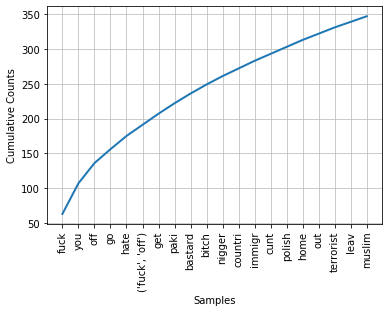

In [38]:
fd = nltk.FreqDist(vocab)
fd.plot(20, cumulative=True)
#fd.xlabel('Most common features')

In [50]:
print(fd.most_common(50))

[('fuck', 63), ('you', 44), ('off', 29), ('go', 20), ('hate', 19), (('fuck', 'off'), 16), ('get', 16), ('paki', 15), ('bastard', 14), ('bitch', 13), ('nigger', 12), ('countri', 11), ('immigr', 11), ('cunt', 10), ('polish', 10), ('home', 10), ('out', 9), ('terrorist', 9), ('leav', 8), ('muslim', 8), ('faggot', 8), ('like', 7), ('back', 7), ('road', 6), ('black', 6), (('off', 'you'), 6), (('fuck', 'off', 'you'), 6), ('come', 6), ('brexit', 5), ('them', 5), ('let', 5), ('mani', 5), ('peopl', 5), ('enough', 5), ('from', 5), ('work', 5), ('daddi', 5), (('fuck', 'paki'), 4), ('make', 4), ('shut', 4), (('you', 'fuck'), 4), ('scum', 4), ('way', 4), ('even', 4), ('one', 4), ('give', 4), ('nail', 4), ('racist', 3), ('white', 3), ('need', 3)]


Is that what you expected?

### Feature selection

We're now going to select a sample of this vocabulary of features. We only want to keep the features that truely matter in identifying hate speech.

This step is important to reduce the  running time of our model as well as improve its accuracy.

#### Keeping the 50 most frequent words

Some rare features are only present in one or two tweet. We know that these are not going to be very useful to teach the model to recognise hate speech.  

Let's only keep the top 50 most frequent features in the dataset.

In [51]:
def get_word_features(wordlist, n):
    fd = nltk.FreqDist(wordlist)
    
    word_features = sorted(fd.items(), key=operator.itemgetter(1), reverse=True)[0:n] 
    word_features = [i[0] for i in word_features ]
    return word_features

# Only keep the top 50 most frequent words
chosen_features = get_word_features(vocab, 50)
print('Number of chosen features: {}/{}'.format(len(chosen_features), len(vocab)))

Number of chosen features: 50/3115


In [52]:
print(chosen_features[0:50])

['fuck', 'you', 'off', 'go', 'hate', ('fuck', 'off'), 'get', 'paki', 'bastard', 'bitch', 'nigger', 'countri', 'immigr', 'cunt', 'polish', 'home', 'out', 'terrorist', 'leav', 'muslim', 'faggot', 'like', 'back', 'road', 'black', ('off', 'you'), ('fuck', 'off', 'you'), 'come', 'brexit', 'them', 'let', 'mani', 'peopl', 'enough', 'from', 'work', 'daddi', ('fuck', 'paki'), 'make', 'shut', ('you', 'fuck'), 'scum', 'way', 'even', 'one', 'give', 'nail', 'racist', 'white', 'need']


### Create input data for classifier

So far, we have chosen a sample of features that we think are important for the model to learn to identify hateful speech.

However, at this stage the classfier won't be able to know which features are responsible for a tweet being labelled as 'hateful'. Is it because of the word 'road' or the word 'bastard' in that tweet?

To be able to learn what counts as hateful and what doesn't, the classifier needs to know the 'hateful value' of each feature in the vocabulary.

In short, we need to tell the model:
- which features are typically present in hateful tweets and which are not,
- which features are typically present in non-hateful tweets and which are not.

This precious information is available in our dataset because it has been manually labelled. So far we have not used the 'class' column in our dataset. We are now going to make use of it!

The idea is to tell the model: 
- for each hateful tweet: these are the features present, and the ones not present. 
- for each non-hateful tweet: these are the features present, and the ones not present.

Let's extract the features present in each tweet:

In [53]:
def extract_features(document):
    document_words = set(document)
    feature_set = {}
    for feature in chosen_features:
        feature_set['contains({})'.format(feature)] = (feature in document_words)
    return feature_set

tweets = [tuple(x) for x in pre_processed_data.values]

feature_set = nltk.classify.apply_features(extract_features, tweets)

In [54]:
print('Number of tweets in training_set: {}'.format(len(feature_set)))

Number of tweets in training_set: 198


Lets' look at the first tweet. Notice at the end, we see that this is a hateful tweet (label = 1).

In [55]:
print(feature_set[0])

({'contains(fuck)': True, 'contains(you)': True, 'contains(off)': False, 'contains(go)': False, 'contains(hate)': False, "contains(('fuck', 'off'))": False, 'contains(get)': False, 'contains(paki)': False, 'contains(bastard)': False, 'contains(bitch)': False, 'contains(nigger)': False, 'contains(countri)': False, 'contains(immigr)': False, 'contains(cunt)': False, 'contains(polish)': False, 'contains(home)': False, 'contains(out)': False, 'contains(terrorist)': False, 'contains(leav)': False, 'contains(muslim)': False, 'contains(faggot)': False, 'contains(like)': False, 'contains(back)': False, 'contains(road)': False, 'contains(black)': False, "contains(('off', 'you'))": False, "contains(('fuck', 'off', 'you'))": False, 'contains(come)': False, 'contains(brexit)': False, 'contains(them)': False, 'contains(let)': False, 'contains(mani)': False, 'contains(peopl)': False, 'contains(enough)': False, 'contains(from)': False, 'contains(work)': False, 'contains(daddi)': False, "contains(('fu

The method is pretty simple. For each tweet, we are looping through our 50 chosen_features and setting a boolean to True if the tweet contains that feature, False otherwise. 

This format is what the classifier needs as input. It is a series of 0s and 1s (numerical) as opposed to text data that they cannot understand.

We can now train the classifier with this training_set!

_________________________________________

## Part 3. Train the classifier

### Split data into train vs test datasets

We want to train the classifer and then test its classifying ability on a brand new dataset that it has never seen before. 

Generally, a 80/20 ratio is a fair split between training and testing set:
- training dataset (80% of the data)
- testing dataset (20% of the data)

Sklearn provides a function called train_test_split to do this easily. Let's split our feature_set into train_data and test_data:

In [56]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(feature_set, test_size=0.20, train_size=0.80)
print('Number of tweets in train data: {}'.format(len(train_data)))
print('Number of tweets in test data: {}'.format(len(test_data)))

Number of tweets in train data: 158
Number of tweets in test data: 40


### Train the model

There are many different types of model to use for classifying text data. The most common one is called Naive Bayesion Classifier and that is the one we are going to use here.

In [57]:
# Naive Bayesian
classifier1 = nltk.NaiveBayesClassifier.train(train_data)
# SHOW FEATURES
classifier1.show_most_informative_features(10)

# Save the model into a pickle file
f = open('classifier.pickle', 'wb')
pickle.dump(classifier1, f)
f.close()

Most Informative Features
         contains(bitch) = True                1 : 0      =      7.2 : 1.0
          contains(fuck) = True                1 : 0      =      5.3 : 1.0
           contains(get) = True                0 : 1      =      4.9 : 1.0
        contains(muslim) = True                1 : 0      =      4.4 : 1.0
     contains(terrorist) = True                1 : 0      =      4.4 : 1.0
        contains(immigr) = True                1 : 0      =      3.1 : 1.0
         contains(black) = True                1 : 0      =      3.1 : 1.0
           contains(let) = True                0 : 1      =      2.9 : 1.0
           contains(you) = True                1 : 0      =      2.4 : 1.0
           contains(one) = True                0 : 1      =      2.3 : 1.0


That's it! The model has been trained on the train_data.

We can see which features the model considers important to decide between hateful speech and non-hateful speech.

- Column 3 shows the ratio of occurence of each informative feature in both categories (hate vs nonhate).
- Column 2 shows the direction of the ratio (which label occurs more frequently). Hate is 1, non-hate is 0. The label on the left is the label most associated with the corresponding feature.

For example, tweets containing the word 'immigrants' are <span style="color:red">5.7 times</span> more likely to be hateful than not.

Now let's test the accuracy of our model on the test_data that we set aside earlier. These are tweets that the model has never seen before. We'll ask the model to classify them and see how its outcome compares with the true label of the tweet.

### Test the classifier

In [58]:
accuracy =  nltk.classify.util.accuracy(classifier1, test_data)
accuracy

0.825

## Part 5. Use the classifier to identify hateful speech

Now try our classifier on a new tweet of your choice. First we need to preprocess the tweet (clean, tokenize, stem and remove stopwords). Then we need to extract its features to look like the right input for the classifier.

In [59]:
testTweet = 'Hello world!'

In [60]:
# Prepare the tweet
def preprocessTweet(tweet):
    
    # clean the tweet
    tweet = cleanTweet(testTweet)
    
    # tokenize the cleaned tweet
    tokenised_tweet = nltk.word_tokenize(tweet)
    
    # remove stop words
    tokenised_tweet_stpwd = [item for item in tokenised_tweet if item not in stopWords]
    
    # stem
    pre_processed_tweet = [ps.stem(word) for word in tokenised_tweet_stpwd]
    
    print('Preprocessed tweet: {}'.format(pre_processed_tweet))
    
    return pre_processed_tweet

preprocessed_tweet = preprocessTweet(testTweet)

Preprocessed tweet: ['hello', 'world']


In [61]:
# extract features
tweet_feature_set = extract_features(preprocessed_tweet) 
print(tweet_feature_set)

{'contains(fuck)': False, 'contains(you)': False, 'contains(off)': False, 'contains(go)': False, 'contains(hate)': False, "contains(('fuck', 'off'))": False, 'contains(get)': False, 'contains(paki)': False, 'contains(bastard)': False, 'contains(bitch)': False, 'contains(nigger)': False, 'contains(countri)': False, 'contains(immigr)': False, 'contains(cunt)': False, 'contains(polish)': False, 'contains(home)': False, 'contains(out)': False, 'contains(terrorist)': False, 'contains(leav)': False, 'contains(muslim)': False, 'contains(faggot)': False, 'contains(like)': False, 'contains(back)': False, 'contains(road)': False, 'contains(black)': False, "contains(('off', 'you'))": False, "contains(('fuck', 'off', 'you'))": False, 'contains(come)': False, 'contains(brexit)': False, 'contains(them)': False, 'contains(let)': False, 'contains(mani)': False, 'contains(peopl)': False, 'contains(enough)': False, 'contains(from)': False, 'contains(work)': False, 'contains(daddi)': False, "contains(('f

In [62]:
# Classify
verdict = classifier1.classify(tweet_feature_set)

if verdict == 0:
    print('Not hateful')
else:
    print('Hateful')



Not hateful


### Activity: try it!

Make some of your own tweets and see whether or not they are hateful

In [67]:
testTweet = "This is a test of hatefullness"

In [68]:
preprocessed_tweet = preprocessTweet(testTweet)
tweet_feature_set = extract_features(preprocessed_tweet) 
verdict = classifier1.classify(tweet_feature_set)

if verdict == 0:
    print('Not hateful')
else:
    print('Hateful with verdict '+str(verdict))

Preprocessed tweet: ['test', 'hateful']
Not hateful
